# Об этом ноутбуке

**В этом ноутбуке сначала обучение модели, затем анализ параметров, то есть показано от самого начала до конца, как получаются предсказания.**

In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet

from sklearn.metrics import mean_absolute_error

np.random.seed(123)

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Generating data

In [3]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def f_4(time, period):
    f = lambda t: 100 * np.cos(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    return y
    

In [4]:
Time = np.arange(0, 200)

# Plotting features

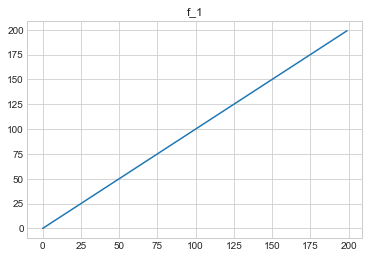

In [5]:
plt.plot(Time,f_1(Time))
plt.title("f_1")
plt.show()

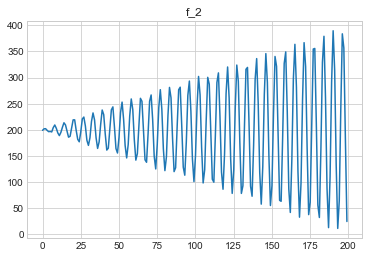

In [6]:
plt.plot(Time,f_2(Time))
plt.title("f_2")
plt.show()

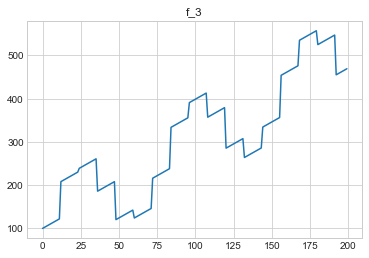

In [7]:
plt.plot(Time,f_3(Time, period=12))
plt.title("f_3")
plt.show()

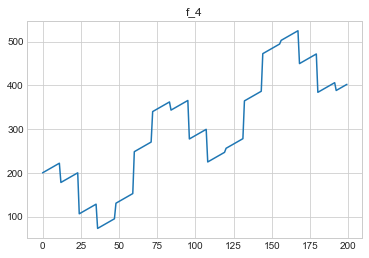

In [8]:
plt.plot(Time,f_4(Time,period=12))
plt.title("f_4")
plt.show()

# Plotting time-series

In [9]:
Exog = np.concatenate([f_1(Time),f_2(Time),f_3(Time, period=12),f_4(Time, period=12)], axis = 1)

In [10]:
Exog.shape

(200, 4)

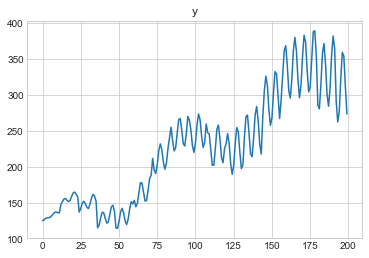

In [11]:
y = generate_ts_1(Exog)

plt.plot(Time, y)
plt.title("y")
plt.show()

# Prophet Approach

In [12]:
data = pd.DataFrame(y)
data.columns = ["y"]
data["ds"] = pd.date_range(start='1/1/2018', periods=len(data), freq='M')

#data_2 = pd.DataFrame({"y": y_2})
#data_2["ds"] = pd.date_range(start='1/1/2018', periods=len(data_2), freq='M')

exog = pd.DataFrame(Exog)
exog.columns = ["f1", "f2", "f3", "f4"]
exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')

print(data.shape, exog.shape)

(200, 2) (200, 5)


In [13]:
data.head()

,y,ds
0,125.175828,2018-01-31
1,126.310841,2018-02-28
2,128.504824,2018-03-31
3,129.027914,2018-04-30
4,129.241621,2018-05-31


In [14]:
exog.head()

,f1,f2,f3,f4,ds
0,0.0,200.703310,100.0,200.0,2018-01-31
1,1.0,200.243366,102.0,202.0,2018-02-28
2,2.0,204.019297,104.0,204.0,2018-03-31
3,3.0,201.111657,106.0,206.0,2018-04-30
4,4.0,196.966483,108.0,208.0,2018-05-31


In [15]:
N = 100

data_train = data.iloc[:N]
data_test = data.iloc[N:]

#data_train_2 = data_2.iloc[:N]
#data_test_2 = data_2.iloc[N:]

exog_train = exog.iloc[:N]
exog_test = exog.iloc[N:]

In [16]:
y_test = data_test["y"].values
del data_test["y"]

#y_test_2 = data_test_2["y"].values
#del data_test_2["y"]

# 1 Experiment: 1-st dataset without exog

In [17]:
# Python
model = Prophet()

#model.add_seasonality(
#    name='montly', period=7, fourier_order=3, prior_scale=0.1)

model.fit(data_train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [18]:
forecast = model.predict(data_test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2034-04-30,531.317414,473.383157,592.723160
96,2034-05-31,545.040123,486.261847,604.649486
97,2034-06-30,547.099527,483.775066,608.814950
98,2034-07-31,544.282996,482.088091,604.664982
99,2034-08-31,541.701026,479.820500,606.426939


In [19]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.29 
 MAE:  121.744


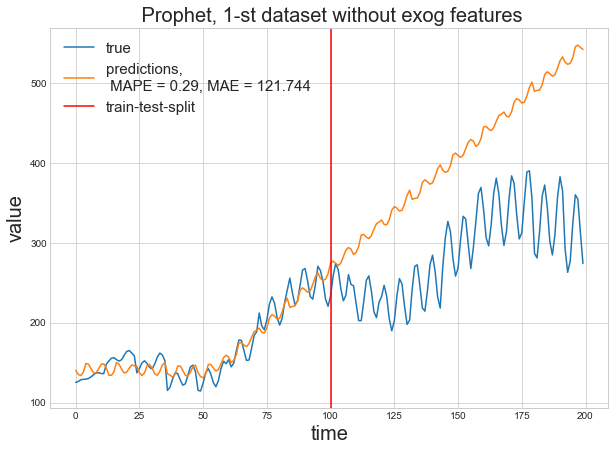

In [20]:
forecast_test = model.predict(data_test)
forecast_train = model.predict(data_train)

plt.figure(figsize=(10,7))

plt.plot(Time, y, label = "true")
plt.plot(Time, np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 1-st dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Merging of features

In [21]:
data_train_joined = pd.merge(data_train, exog_train, on = "ds")

data_test_joined = pd.merge(data_test, exog_test, on = "ds")

print(data_train_joined.shape, data_test_joined.shape)
data_train_joined.head()

(100, 6) (100, 5)


,y,ds,f1,f2,f3,f4
0,125.175828,2018-01-31,0.0,200.703310,100.0,200.0
1,126.310841,2018-02-28,1.0,200.243366,102.0,202.0
2,128.504824,2018-03-31,2.0,204.019297,104.0,204.0
3,129.027914,2018-04-30,3.0,201.111657,106.0,206.0
4,129.241621,2018-05-31,4.0,196.966483,108.0,208.0


# 3-rd Experiment: 1-st dataset with exog features

In [22]:
model = Prophet()

model.add_regressor("f1")
model.add_regressor("f2")
model.add_regressor("f3")
model.add_regressor("f4")

model.fit(data_train_joined)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [23]:
forecast = model.predict(data_test_joined)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2034-04-30,323.320186,321.643879,325.322858
96,2034-05-31,359.940383,358.241211,361.991621
97,2034-06-30,354.483554,352.747177,356.554267
98,2034-07-31,312.500018,310.758321,314.610905
99,2034-08-31,273.923753,272.158338,276.053953


In [24]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.0 
 MAE:  0.065


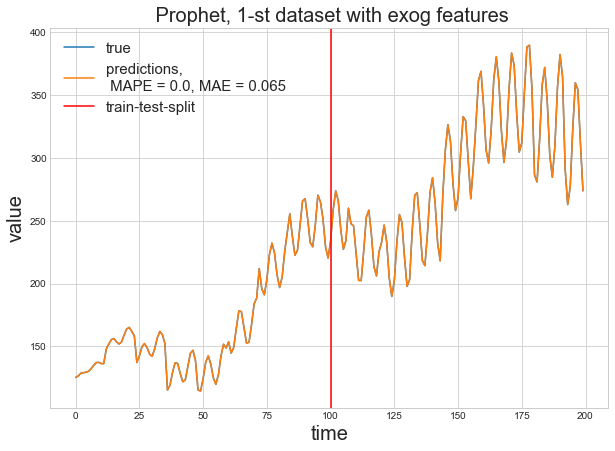

In [25]:
forecast_test = model.predict(data_test_joined)
forecast_train = model.predict(data_train_joined)

plt.figure(figsize=(10,7))

plt.plot(Time, y, label = "true")
plt.plot(Time, np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 1-st dataset with exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Parameters analyzing

In [26]:
model.params

{'k': array([[0.32466375]]),
 'm': array([[0.46168014]]),
 'delta': array([[-1.29649883e-03,  5.35644118e-05,  2.65250534e-03,
         -2.13336286e-03,  4.34400847e-05, -8.07883906e-05,
         -1.15424303e-03, -4.06197047e-04,  1.48873527e-03,
          8.74055726e-04, -8.93007005e-04,  2.88560626e-04,
          1.46927734e-03, -3.22278342e-03,  2.49917808e-03,
         -1.22115914e-03,  3.01523459e-04,  2.61134041e-04,
          2.17513410e-03, -3.67254073e-03,  2.04322316e-03,
         -1.67334201e-03, -8.61456463e-04,  2.07496766e-03,
          1.89593124e-04]]),
 'sigma_obs': array([[0.00015603]]),
 'beta': array([[ 4.41533403e-05, -5.05875989e-05, -4.68325649e-06,
          7.96252547e-05,  7.42467447e-06,  1.07728145e-05,
         -9.94535874e-06,  3.69469074e-05, -1.52940044e-05,
          1.61583284e-05,  2.40800154e-05,  1.38995607e-05,
          3.31198946e-05, -1.73962647e-05,  1.88108769e-05,
         -3.15290079e-05,  3.23931762e-05, -2.40675230e-05,
          4.1797680

# Путь теста:

In [27]:
data_test_joined.head()

,ds,f1,f2,f3,f4
0,2026-05-31,100.0,150.128491,398.935825,285.449997
1,2026-06-30,101.0,244.825616,400.935825,287.449997
2,2026-07-31,102.0,300.813181,402.935825,289.449997
3,2026-08-31,103.0,264.778953,404.935825,291.449997
4,2026-09-30,104.0,166.407257,406.935825,293.449997


In [28]:
df = model.setup_dataframe(data_test_joined)
df.head(5)

,ds,f1,f2,f3,f4,floor,t
0,2026-05-31,1.740690,-1.198350,2.350291,0.729378,0,1.010296
1,2026-06-30,1.775159,1.106529,2.375118,0.750430,0,1.020259
2,2026-07-31,1.809628,2.469238,2.399945,0.771482,0,1.030555
3,2026-08-31,1.844097,1.592183,2.424772,0.792534,0,1.040850
4,2026-09-30,1.878566,-0.802134,2.449599,0.813586,0,1.050814


In [29]:
data_test_joined['f1'].mean()

149.5

In [30]:
((data_test_joined['f1'] - data_train_joined['f1'].mean()) / data_train_joined['f1'].std())[:5]

0    1.740690
1    1.775159
2    1.809628
3    1.844097
4    1.878566
Name: f1, dtype: float64

**То есть идет стандартизация по параметрам mu и sigma, обученных на train. Разберемся, как получить тренд.**

In [31]:
changepoint_ts = model.changepoints_t

k = np.nanmean(model.params['k'])
m = np.nanmean(model.params['m'])
deltas = np.nanmean(model.params['delta'], axis = 0)
gammas = -changepoint_ts * deltas

In [32]:
start = model.start
t_scale = model.t_scale
t = ((data_test["ds"] - start)/t_scale).values

In [33]:
# Копипаста их кода из piecewise_linear
gammas = -changepoint_ts * deltas
k_t = k * np.ones_like(t)
m_t = m * np.ones_like(t)

for s, t_s in enumerate(changepoint_ts):
    indx = t >= t_s
    k_t[indx] += deltas[s]
    m_t[indx] += gammas[s]

trend = k_t * t + m_t

In [34]:
trend = trend * model.y_scale + 0

In [35]:
trend[:3]

array([213.39272472, 214.2669446 , 215.17030515])

In [36]:
forecast.trend[:3]

0    213.392725
1    214.266945
2    215.170305
Name: trend, dtype: float64

**Значения совпали.**

**Как получается тренд мы уже поняли. Давайте поймем, как получить seasonal_components.**

In [37]:
seasonal_components = model.predict_seasonal_components(df)
seasonal_components.head(5)

,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,f1,f1_lower,f1_upper,f2,...,f3_upper,f4,f4_lower,f4_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper
0,20.237942,20.237942,20.237942,20.231941,20.231941,20.231941,-32.103540,-32.103540,-32.103540,-12.308479,...,47.322201,17.321760,17.321760,17.321760,0.006001,0.006001,0.006001,0.0,0.0,0.0
1,44.289930,44.289930,44.289930,44.269913,44.269913,44.269913,-32.739254,-32.739254,-32.739254,11.365367,...,47.822082,17.821717,17.821717,17.821717,0.020017,0.020017,0.020017,0.0,0.0,0.0
2,58.634903,58.634903,58.634903,58.630673,58.630673,58.630673,-33.374967,-33.374967,-33.374967,25.362002,...,48.321964,18.321675,18.321675,18.321675,0.004231,0.004231,0.004231,0.0,0.0,0.0
3,49.973392,49.973392,49.973392,49.986406,49.986406,49.986406,-34.010681,-34.010681,-34.010681,16.353610,...,48.821846,18.821632,18.821632,18.821632,-0.013014,-0.013014,-0.013014,0.0,0.0,0.0
4,25.757078,25.757078,25.757078,25.758060,25.758060,25.758060,-34.646395,-34.646395,-34.646395,-8.238862,...,49.321727,19.321589,19.321589,19.321589,-0.000981,-0.000981,-0.000981,0.0,0.0,0.0


In [38]:
seasonal_features, _, component_cols, _ = model.make_all_seasonality_features(df)

In [39]:
seasonal_features.head(5)

,yearly_delim_1,yearly_delim_2,yearly_delim_3,yearly_delim_4,yearly_delim_5,yearly_delim_6,yearly_delim_7,yearly_delim_8,yearly_delim_9,yearly_delim_10,...,yearly_delim_15,yearly_delim_16,yearly_delim_17,yearly_delim_18,yearly_delim_19,yearly_delim_20,f1,f2,f3,f4
0,0.532227,-0.846602,-0.901169,0.433469,0.993635,0.112651,-0.781257,-0.624210,0.329192,0.944263,...,0.975336,-0.220724,-0.943196,-0.332235,0.621687,0.783266,1.740690,-1.198350,2.350291,0.729378
1,0.045141,-0.998981,-0.090190,0.995925,0.135055,-0.990838,-0.179645,0.983732,0.223868,-0.974619,...,-0.353445,0.935455,0.395312,-0.918547,-0.436373,0.899766,1.775159,1.106529,2.375118,0.750430
2,-0.468965,-0.883217,0.828396,0.560143,-0.994341,-0.106239,0.928041,-0.372479,-0.644981,0.764198,...,-0.691351,-0.722519,0.949449,0.313921,-0.985787,0.167998,1.809628,2.469238,2.399945,0.771482
3,-0.852837,-0.522178,0.890665,-0.454661,-0.077334,0.997005,-0.809901,-0.586567,0.923158,-0.384421,...,0.950122,-0.311879,-0.230151,0.973155,-0.709763,-0.704441,1.844097,1.592183,2.424772,0.792534
4,-0.999445,-0.033324,0.066610,-0.997779,0.995005,0.099823,-0.132924,0.991126,-0.986146,-0.165878,...,-0.263489,0.964662,-0.955346,-0.295489,0.327160,-0.944969,1.878566,-0.802134,2.449599,0.813586


**По умолчанию параметры seasonalities слудющие:**

In [40]:
model.seasonalities

{'yearly': {'period': 365.25,
  'fourier_order': 10,
  'prior_scale': 10.0,
  'mode': 'additive'}}

**Поэтому мы и получили 20 колонок для yeraly seasonal фичи + в конце были добавлены регрессоры (уже стандартизированные)**

**Формула для подсчета строк и столбцов таблицы, которые отвечают за сезонность - в данном случае yearly - следующая:**

$$
A_[i, j] = [j \% 2 == 0]*Cos(2 * pi * (i + 1) / period) + [j \% 2 == 1]*Sin(2 * pi * (i + 1) / period)
$$


**Поймем, как считается матрица component_cols**

In [41]:
component_cols

component,additive_terms,extra_regressors_additive,f1,f2,f3,f4,yearly,multiplicative_terms
col,,,,,,,,
0,1,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,1,0
3,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0
5,1,0,0,0,0,0,1,0
6,1,0,0,0,0,0,1,0
7,1,0,0,0,0,0,1,0
8,1,0,0,0,0,0,1,0


**Это просто cross-tab матрица, которая показывает для каждой фичи, в каких колонках она встретилась в seasonal_matrix + там добавляют специальные имена, чтобы различать регрессоры и не регрессоры и так далее.**

**Теперь поймем, как учитываются добавки 'additive_terms', 'multiplicative_terms' для окончательного предсказания. Заметим, что эти две колонки будут всегда, при этом их сумма всегда будет равна 1.**

In [42]:
# просто извлекли данные
X = seasonal_features.values

# для каждой компоненты считаем
for component in component_cols.columns:
    
    # Здесь просто по факту оставляем у beta ненулевыми только те, где стоят 1
    # Это эквивалентно тому, что мы просто составили маску, чтобы потом в матрице seasonal_features взять 
    # только нужные нам параметры
    beta_c = model.params['beta'] * component_cols[component].values
    
    # Это обычный дот в данном случае, то есть для каждой даты просто
    # умножаем шкалированное значение на обученную beta и суммируем
    comp = np.matmul(X, beta_c.transpose())
    
    #  Если добавка аддитивная - то дополнительно шкалируем, что тоже очевидно
    if component in model.component_modes['additive']:
         comp *= model.y_scale
    
    # Именно это будет лежать в 'multiplicative' и 'additive'
    df[component] = np.nanmean(comp, axis=1)
    

In [43]:
df.head(5)

,ds,f1,f2,f3,f4,floor,t,additive_terms,extra_regressors_additive,yearly,multiplicative_terms
0,2026-05-31,-32.103540,-12.308479,47.322201,17.321760,0,1.010296,20.237942,20.231941,0.006001,0.0
1,2026-06-30,-32.739254,11.365367,47.822082,17.821717,0,1.020259,44.289930,44.269913,0.020017,0.0
2,2026-07-31,-33.374967,25.362002,48.321964,18.321675,0,1.030555,58.634903,58.630673,0.004231,0.0
3,2026-08-31,-34.010681,16.353610,48.821846,18.821632,0,1.040850,49.973392,49.986406,-0.013014,0.0
4,2026-09-30,-34.646395,-8.238862,49.321727,19.321589,0,1.050814,25.757078,25.758060,-0.000981,0.0


In [44]:
forecast_test.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,f4,f4_lower,f4_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2026-05-31,213.392725,233.573603,233.682417,213.392492,213.392876,20.237942,20.237942,20.237942,20.231941,...,17.321760,17.321760,17.321760,0.006001,0.006001,0.006001,0.0,0.0,0.0,233.630667
1,2026-06-30,214.266945,258.504171,258.611311,214.264398,214.269137,44.289930,44.289930,44.289930,44.269913,...,17.821717,17.821717,17.821717,0.020017,0.020017,0.020017,0.0,0.0,0.0,258.556874
2,2026-07-31,215.170305,273.746571,273.863413,215.164129,215.176316,58.634903,58.634903,58.634903,58.630673,...,18.321675,18.321675,18.321675,0.004231,0.004231,0.004231,0.0,0.0,0.0,273.805208
3,2026-08-31,216.073666,265.988807,266.103442,216.063436,216.084411,49.973392,49.973392,49.973392,49.986406,...,18.821632,18.821632,18.821632,-0.013014,-0.013014,-0.013014,0.0,0.0,0.0,266.047058
4,2026-09-30,216.947886,242.648932,242.761515,216.932011,216.963648,25.757078,25.757078,25.757078,25.758060,...,19.321589,19.321589,19.321589,-0.000981,-0.000981,-0.000981,0.0,0.0,0.0,242.704964


**Видно, что совпало.**

**Итого, можно выписать финальную формулу, без учета составляющей для праздников.**

Эта формула схематична, в целом отражает главный концепт, но не учитывает некоторые детали, например, что время тут "стандартизированное" и некоторые другие.

$$
\small
\begin{eqnarray}
y_t = \left[(k + \sum_{i \in changepoints}\delta_i) * t + m + \sum_{i \in changepoints}(-changepoint_i * \delta_i)\right] * \\ *  
\left[1 + \sum_{multiplicative-features} \beta \left( \sum_{i \in seasonal-features}  ([i \% 2 == 0] * Cos\left(\frac{2 * \pi * t}{period}\right) + [i \% 2 == 1] * Sin\left(\frac{2 * \pi * t}{period}\right)  + \sum_{i \in regressors} \frac{regressors_i - mu_{train}}{std_{train}}\right] \right) + \\
+ \sum_{additive-features} * y_{scale} * \beta \left( \sum_{i \in seasonal-features} ([i \% 2 == 0] * Cos\left(\frac{2 * \pi * t}{period}\right) + [i \% 2 == 1] * Sin\left(\frac{2 * \pi * t}{period}\right) + \sum_{i \in regressors} \frac{regressors_i - mu_{train}}{std_{train}} \right)
\end{eqnarray}
$$

# Более подробный пример

**Давайте рассмотрим модель, в которой будем делать предсказание только для одной точки из теста, то есть следующей даты. Также установим в качестве fourier_order значение 1, то есть у нас будет только одна сезонная компонента по умолчанию, а значит всего 1 * 2 стобца в матрице для сезонности. Также добавим всего 1 регрессорь то есть матрица seasonal_features будет иметь 3 столбца, а component_сols будет иметь, соответственно, 3 строки. Сделаем также всего 1 changepoint для простоты.**

In [81]:
data_train.head(5)

,y,ds
0,125.175828,2018-01-31
1,126.310841,2018-02-28
2,128.504824,2018-03-31
3,129.027914,2018-04-30
4,129.241621,2018-05-31


In [82]:
exog_train.head(5)

,f1,f2,f3,f4,ds
0,0.0,200.703310,100.0,200.0,2018-01-31
1,1.0,200.243366,102.0,202.0,2018-02-28
2,2.0,204.019297,104.0,204.0,2018-03-31
3,3.0,201.111657,106.0,206.0,2018-04-30
4,4.0,196.966483,108.0,208.0,2018-05-31


In [83]:
#data_train_joined_1_regressor = pd.merge(data_train, exog_train[["f1", "ds"]], on = "ds")

#data_test_joined_1_regressor = pd.merge(data_test, exog_test[["f1", "ds"]], on = "ds")

#data_test_joined_1_regressor = data_test_joined_1_regressor[:1].copy()

data_train_joined_1_regressor = pd.merge(data_train, exog_train[["f1", "f2", "ds"]], on = "ds")

data_test_joined_1_regressor = pd.merge(data_test, exog_test[["f1", "f2", "ds"]], on = "ds")

data_test_joined_1_regressor = data_test_joined_1_regressor[:3].copy()



print(data_train_joined_1_regressor.shape, data_test_joined_1_regressor.shape)
data_train_joined_1_regressor.head()

(100, 4) (3, 3)


,y,ds,f1,f2
0,125.175828,2018-01-31,0.0,200.703310
1,126.310841,2018-02-28,1.0,200.243366
2,128.504824,2018-03-31,2.0,204.019297
3,129.027914,2018-04-30,3.0,201.111657
4,129.241621,2018-05-31,4.0,196.966483


In [84]:
data_test_joined_1_regressor

,ds,f1,f2
0,2026-05-31,100.0,150.128491
1,2026-06-30,101.0,244.825616
2,2026-07-31,102.0,300.813181


In [85]:
# Python
model = Prophet(n_changepoints = 1)

model.add_seasonality(name='yearly', period = 12, fourier_order = 1, prior_scale = 0.1, mode = 'multiplicative')
model.add_seasonality(name='monthly', period = 30, fourier_order = 1, prior_scale = 0.1, mode = 'multiplicative')

model.add_regressor("f1", mode = "multiplicative")
model.add_regressor("f2", mode = "additive")


model.fit(data_train_joined_1_regressor)

INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [86]:
model.seasonalities

{'yearly': {'period': 12,
  'fourier_order': 1,
  'prior_scale': 0.1,
  'mode': 'multiplicative'},
 'monthly': {'period': 30,
  'fourier_order': 1,
  'prior_scale': 0.1,
  'mode': 'multiplicative'}}

In [87]:
forecast = model.predict(data_test_joined_1_regressor)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,2026-05-31,206.860814,223.769672,242.717304,206.860814,206.860814,-11.803879,-11.803879,-11.803879,-11.803879,...,0.053630,0.053630,0.053630,0.184837,0.184837,0.184837,-0.000208,-0.000208,-0.000208,233.292467
1,2026-06-30,208.296051,248.461484,268.178758,208.296051,208.296051,10.899431,10.899431,10.899431,10.899431,...,0.053630,0.053630,0.053630,0.187854,0.187854,0.187854,0.000208,0.000208,0.000208,258.324819
2,2026-07-31,209.779130,255.884738,276.002748,209.779130,209.779130,24.322258,24.322258,24.322258,24.322258,...,0.015617,0.015617,0.015617,0.150046,0.150046,0.150046,-0.002190,-0.002190,-0.002190,265.577951


In [88]:
model.params

{'k': array([[0.21095304]]),
 'm': array([[0.48365483]]),
 'delta': array([[0.32172953]]),
 'sigma_obs': array([[0.02879368]]),
 'beta': array([[-0.00402039, -0.00020758, -0.1057613 , -0.15195043,  0.07549587,
          0.03642472]])}

**Теперь получим такой же ответ руками.**

In [89]:
df_train = model.setup_dataframe(data_train_joined_1_regressor)
df_train.head(5)

,y,ds,f1,f2,floor,t,y_scaled
0,125.175828,2018-01-31,-1.706220,0.032615,0,0.000000,0.462888
1,126.310841,2018-02-28,-1.671751,0.021420,0,0.009299,0.467085
2,128.504824,2018-03-31,-1.637282,0.113324,0,0.019595,0.475198
3,129.027914,2018-04-30,-1.602813,0.042554,0,0.029558,0.477133
4,129.241621,2018-05-31,-1.568344,-0.058338,0,0.039854,0.477923


In [90]:
df_test = model.setup_dataframe(data_test_joined_1_regressor)
df_test.head(5)

,ds,f1,f2,floor,t
0,2026-05-31,1.740690,-1.198350,0,1.010296
1,2026-06-30,1.775159,1.106529,0,1.020259
2,2026-07-31,1.809628,2.469238,0,1.030555


**Стандартизация данных**

In [91]:
mu_train = data_train_joined_1_regressor['f1'].mean()
std_train = data_train_joined_1_regressor['f1'].std()

((data_test_joined_1_regressor['f1'] - mu_train) / std_train)

0    1.740690
1    1.775159
2    1.809628
Name: f1, dtype: float64

 **Стандартизация времени**

In [92]:
start = data_train_joined_1_regressor["ds"].min() # Начало отсчета
t_scale = data_train_joined_1_regressor["ds"].max() - start # timedelta - по факту просто длина обучающей выборки

t = ((data_test_joined_1_regressor["ds"] - start) / t_scale).values
t

array([1.01029558, 1.02025905, 1.03055463])

**То есть стандартизация фичей идет по параметрам mu и sigma, обученных на train. С временем аналолгично. Заметим, что получили такие же значения. Разберемся, как получить тренд.**

In [93]:
changepoint_ts = model.changepoints_t
changepoint_ts

array([0.79840585])

**Changepoint, полученный уже для стандартизированного времени.**

In [94]:
i0, i1 = df_train['ds'].idxmin(), df_train['ds'].idxmax() # Просто извлекли индексы минимального и максимального

T = df_train['t'].iloc[i1] - df_train['t'].iloc[i0] # Посчитали разницу во времени для стандартизированного времени

k = (df_train['y_scaled'].iloc[i1] - df_train['y_scaled'].iloc[i0]) / T

m = df_train['y_scaled'].iloc[i0] - k * df_train['t'].iloc[i0]

k, m

(0.35183758694317313, 0.4628878982684892)

**Дальше эти параметры передаются stan и он их отимизирует. После оптимизации мы получим следующие параметры.**

In [95]:
k = np.nanmean(model.params['k'])
m = np.nanmean(model.params['m'])
k, m

(0.21095304227354492, 0.4836548328614881)

In [96]:
deltas = np.nanmean(model.params['delta'], axis = 0)
gammas = -changepoint_ts * deltas

In [97]:
# Копипаста их кода из piecewise_linear
gammas = -changepoint_ts * deltas

k_t = k * np.ones_like(t)
m_t = m * np.ones_like(t)

for s, t_s in enumerate(changepoint_ts):
    indx = t >= t_s
    k_t[indx] += deltas[s]
    m_t[indx] += gammas[s]

trend = k_t * t + m_t

In [98]:
floor = 0
trend = trend * model.y_scale + floor

In [99]:
trend

array([206.86081446, 208.2960515 , 209.77912977])

In [100]:
forecast.trend

0    206.860814
1    208.296051
2    209.779130
Name: trend, dtype: float64

**Значения совпали.**

**Как получается тренд мы уже поняли. Давайте поймем, как получить seasonal_components.**

In [101]:
seasonal_components = model.predict_seasonal_components(df_test)
seasonal_components.head(5)

,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,f1,...,f2_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper
0,-11.803879,-11.803879,-11.803879,-11.803879,-11.803879,-11.803879,0.131415,0.131415,0.131415,0.131415,...,-11.803879,0.053630,0.053630,0.053630,0.184837,0.184837,0.184837,-0.000208,-0.000208,-0.000208
1,10.899431,10.899431,10.899431,10.899431,10.899431,10.899431,0.134017,0.134017,0.134017,0.134017,...,10.899431,0.053630,0.053630,0.053630,0.187854,0.187854,0.187854,0.000208,0.000208,0.000208
2,24.322258,24.322258,24.322258,24.322258,24.322258,24.322258,0.136619,0.136619,0.136619,0.136619,...,24.322258,0.015617,0.015617,0.015617,0.150046,0.150046,0.150046,-0.002190,-0.002190,-0.002190


In [102]:
seasonal_features, _, component_cols, _ = model.make_all_seasonality_features(df_test)

In [103]:
seasonal_features.head(5)

,yearly_delim_1,yearly_delim_2,monthly_delim_1,monthly_delim_2,f1,f2
0,-8.681856e-13,1.000000,-0.951057,0.309017,1.740690,-1.198350
1,-7.832139e-13,-1.000000,-0.951057,0.309017,1.775159,1.106529
2,5.000000e-01,0.866025,-0.866025,0.500000,1.809628,2.469238


**Мы получили 3 колонки, как это и ожидалось.  yeraly seasonal фичи + в конце был добавлен регрессор (уже стандартизированный)**

**Формула для подсчета строк и столбцов таблицы, которые отвечают за сезонность - в данном случае yearly - следующая:**

$$
A_[i, j] = [j \% 2 == 0]*Cos(2 * pi * (i + 1) / period) + [j \% 2 == 1]*Sin(2 * pi * (i + 1) / period)
$$

In [68]:
t = np.array(
    (data_test_joined_1_regressor["ds"] - pd.datetime(1970, 1, 1))
    .dt.total_seconds()
    .astype(np.float)
) / (3600 * 24.)
t

array([20604.])

In [69]:
model.seasonalities

{'yearly': {'period': 12,
  'fourier_order': 1,
  'prior_scale': 0.1,
  'mode': 'multiplicative'}}

In [70]:
period = model.seasonalities['yearly']["period"]
series_order = model.seasonalities["yearly"]["fourier_order"]

np.column_stack([
    fun((2.0 * (i + 1) * np.pi * t / period))
    for i in range(series_order)
    for fun in (np.sin, np.cos)
])

array([[-8.68185634e-13,  1.00000000e+00]])

**Заметим, что для сезонной компоненты получили те же значения, + регрессор совпал.**

**Поймем, как считается матрица component_cols**

In [71]:
component_cols

component,additive_terms,extra_regressors_additive,f1,multiplicative_terms,yearly
col,,,,,
0,0,0,0,1,1
1,0,0,0,1,1
2,1,1,1,0,0


**Это просто cross-tab матрица, которая показывает для каждой фичи, в каких колонках она встретилась в seasonal_matrix + там добавляют специальные имена, чтобы различать регрессоры и не регрессоры и так далее.**

**Теперь поймем, как учитываются добавки 'additive_terms', 'multiplicative_terms' для окончательного предсказания. Заметим, что эти две колонки будут всегда, при этом их сумма всегда будет равна 1.**

In [72]:
# просто извлекли данные
X = seasonal_features.values

# для каждой компоненты считаем
for component in component_cols.columns:
    
    # Здесь просто по факту оставляем у beta ненулевыми только те, где стоят 1
    # Это эквивалентно тому, что мы просто составили маску, чтобы потом в матрице seasonal_features взять 
    # только нужные нам параметры
    beta_c = model.params['beta'] * component_cols[component].values
    
    # Это обычный дот в данном случае, то есть для каждой даты просто
    # умножаем шкалированное значение на обученную beta и суммируем
    comp = np.matmul(X, beta_c.transpose())
    
    #  Если добавка аддитивная - то дополнительно шкалируем, что тоже очевидно
    if component in model.component_modes['additive']:
         comp *= model.y_scale
    
    # Именно это будет лежать в 'multiplicative' и 'additive'
    df_test[component] = np.nanmean(comp, axis=1)
    

In [73]:
df_test

,ds,f1,floor,t,additive_terms,extra_regressors_additive,multiplicative_terms,yearly
0,2026-05-31,-17.257362,0,1.010296,-17.257362,-17.257362,0.00096,0.00096



**Пусть $r$ обозначает стандартизированное значение для регрессора.
$\phi_{sin}$, $\phi_{cos}$ обозначают соответствующие коэффициенты в матрице seasonal_components.**

**Тогда есть аддитивная составляющая в данном случае просто $\beta_{3} * r * y_{scale}$, а мультипликативная: $\phi_{sin} * \beta_{1} + \phi_{cos} * \beta_{2}$**
**
**Проверим.**

In [74]:
additive = model.params["beta"].squeeze()[2] * seasonal_features["f1"] * model.y_scale
additive

0   -17.257362
Name: f1, dtype: float64

In [75]:
seasonal_components["additive_terms"]

0   -17.257362
Name: additive_terms, dtype: float64

In [76]:
multiplicative = (model.params["beta"].squeeze()[0] * seasonal_features["yearly_delim_1"] + 
                  model.params["beta"].squeeze()[1] * seasonal_features["yearly_delim_2"])
multiplicative

0    0.00096
dtype: float64

In [77]:
seasonal_components["multiplicative_terms"]

0    0.00096
Name: multiplicative_terms, dtype: float64

**Additive и multiplicative компоненты совпали. Выпишим окончательный проноз.**

In [78]:
pred = trend * (1 + multiplicative) + additive
pred

0    228.143678
dtype: float64

In [79]:
forecast = model.predict(data_test_joined_1_regressor)
forecast["yhat"]

0    228.143678
Name: yhat, dtype: float64

**Видно, что все совпало. Крутяк :-)**

In [80]:
model.seasonality_prior_scale

10.0